<a href="https://colab.research.google.com/github/caardila41/Simulacion-de-redes-5G/blob/main/intro_py3gpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py3gpp
!pip install sigmf

In [ ]:
from google.colab import drive
drive.mount('/mnt/drive')

In [ ]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *

In [ ]:
handle = sigmf.sigmffile.fromfile('/mnt/drive/MyDrive/30720KSPS_dl_signal.sigmf-data')
delta_f = 0
f = 1
mu = 0
apply_fine_CFO = 0

waveform = handle.read_samples()
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)


# Time Domain Representation

Plot: The real and imaginary parts of the waveform plotted against time (sample index).

## Purpose

* Amplitude and Phase Variations: Observe how the amplitude and phase of the signal change over time.

* Signal Integrity: Detect anomalies like sudden spikes, drops, or other irregularities in the waveform.

* Time-Specific Events: Identify specific events or patterns in the signal that occur at particular times, such as pulses or bursts.

## Information Extracted

* Signal Dynamics: Understanding the behavior of the signal over time.
* Transients: Detecting short-term changes or transient phenomena.
* Synchronization: Checking if the signal maintains a consistent pattern or if there are any timing issues.

In [ ]:
# Plot the waveform in the time domain
mini=waveform[:10000]
plt.figure(figsize=(12, 6))
plt.plot(np.real(mini), label='Real Part')
plt.plot(np.imag(mini), label='Imaginary Part')
plt.title('Time Domain Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')  # Fixed legend location
plt.grid(True)
plt.show()

# Frequency Domain Representation
Plot: The magnitude of the Fourier Transform of the signal plotted against frequency.

## Purpose

* Spectral Content: Analyze the frequency components present in the signal.
* Bandwidth: Determine the range of frequencies that the signal occupies.
* Harmonics and Spurious Signals: Identify harmonic frequencies and any spurious or unwanted signals.

## Information Extracted

* Signal Composition: Understanding what frequencies are present and their respective magnitudes.
* Interference and Noise: Identifying and analyzing the presence of noise or interference in specific frequency ranges.
* Filter Design: Informing the design of filters to isolate or remove specific frequency components.

In [ ]:
# Plot the waveform in the frequency domain
waveform_fft = np.fft.fftshift(np.fft.fft(mini))
frequencies = np.fft.fftshift(np.fft.fftfreq(len(mini), d=1/fs))

plt.figure(figsize=(12, 6))
plt.plot(frequencies, 20 * np.log10(np.abs(waveform_fft)))
plt.title('Frequency Domain Waveform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

# In-Phase/Quadrature (Constellation) Plot
Plot: The real part (in-phase) of the signal on the x-axis and the imaginary part (quadrature) on the y-axis.

## Purpose:

* Modulation Scheme: Visualize the modulation technique used (e.g., QAM, PSK).
*Signal Quality: Assess the quality and integrity of the modulation by observing the clustering and spread of points.
*Error Detection: Identify issues like noise, phase jitter, or amplitude variations that can affect the modulation.

## Information Extracted

* Modulation Analysis: Determine the type of modulation and its performance.
* Error Vector Magnitude (EVM): Assess the accuracy of the transmitted symbols relative to their ideal positions.
* Noise and Distortion: Observe the spread and scatter of points to detect noise and distortion effects.

In [ ]:
# Scatter plot for the constellation diagram
plt.figure(figsize=(8, 8))
plt.scatter(np.real(mini), np.imag(mini), s=1, alpha=0.6)
plt.title('Constellation Diagram')
plt.xlabel('In-Phase (Real)')
plt.ylabel('Quadrature (Imaginary)')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [ ]:
waveform =  waveform * np.exp(-1j*2*np.pi*delta_f/fs*(np.arange(len(waveform))))
# SC polar decoder can decode this when repeated bits in nrRateMatchPolar() are used
np.random.seed(69) # to get reproducible noise
noise = ((np.random.rand(waveform.shape[0]) - 0.5) + 1j*(np.random.rand(waveform.shape[0]) - 0.5))*0.9
SNR = 20*np.log10((np.linalg.norm(waveform) / np.linalg.norm(noise)))
waveform += noise
print(f'SNR = {SNR} dB')

# Primary Synchronization Signal (PSS) Detection in   5G NR (New Radio) signal.

The detection process involves generating reference waveforms for different possible NID2 values, correlating them with the received signal, and identifying the NID2 value that yields the highest correlation peak.

In [ ]:
# Define carrier configurations for different bandwidths
# 5 MHz -> 25 PRBs (FFT-LEN 512)
# 10 MHz -> 52 PRBs (FFT-LEN 1024)
# 20 MHz -> 106 PRBs (FFT-LEN 2048)
carrier = nrCarrierConfig(NSizeGrid=106, SubcarrierSpacing=15 * 2**mu)

# Get OFDM information for the configured carrier
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']
print(f'Nfft = {Nfft}')  # Print the FFT length

# Initialize arrays to store peak correlation values and their indices
peak_value = np.zeros(3)
peak_index = np.zeros(3, dtype='int')

# Define constants
PSS_LEN = 128  # Length of the Primary Synchronization Signal
NRE_PER_PRB = 12  # Number of Resource Elements per Physical Resource Block

# Calculate indices where the PSS will be inserted in the resource grid
pssIndices = np.arange((carrier.NSizeGrid * NRE_PER_PRB // 2 - PSS_LEN // 2),
                       (carrier.NSizeGrid * NRE_PER_PRB // 2 + PSS_LEN // 2 - 1))

# Set up subplots for plotting correlation results for each NID2 value
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)

# Loop over possible NID2 values (0, 1, 2)
for current_NID2 in np.arange(3, dtype='int'):
    # Generate an empty resource grid for the current carrier configuration
    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:, 0]  # Consider only the first OFDM symbol in the slot

    # Insert the PSS at the calculated indices in the resource grid
    slotGrid[pssIndices] = nrPSS(current_NID2)

    # Modulate the resource grid to create the reference waveform
    [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, SampleRate=fs)

    # Remove the cyclic prefix (CP) from the reference waveform
    refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]

    # Correlate the received waveform with the reference waveform over 25 ms
    temp = scipy.signal.correlate(waveform[:int(25e-3 * fs)], refWaveform, 'valid')

    # Identify the peak correlation value and its index for the current NID2
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])

    # Calculate time in milliseconds for plotting
    t_corr = np.arange(temp.shape[0]) / fs * 1e3

    # Plot the correlation result for the current NID2
    axs[current_NID2].plot(t_corr, np.abs(temp))

# Determine the NID2 with the highest peak correlation value
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2}')

# Set common labels for the plots
plt.xlabel('Time (ms)')
plt.show()


# Timing offset based on the detected NID2.

---



In [ ]:
# Additional configurations for timing offset estimation
nrbSSB = 20  # Number of Resource Blocks for SSB
scsSSB = 15 * 2**mu  # Subcarrier Spacing for SSB
nSlot = 0  # Initial slot number
rxSampleRate = fs  # Sample rate of the received waveform

# Two cases for timing offset calculation
if False:
    # Manual timing offset calculation
    cp1 = np.round(5.2e-6 * fs * 2**(-mu))  # First CP length in samples
    cp2 = np.round(4.7e-6 * fs * 2**(-mu))  # Second CP length in samples
    timingOffset = int(35264 - 2048 - cp1 - cp2)
else:
    # Calculate reference grid for timing estimation
    refGrid = np.zeros((nrbSSB * 12, 2), np.complex128)
    refGrid[nrPSSIndices(), 1] = nrPSS(detected_NID2)  # Insert detected PSS in the reference grid

    # Timing offset estimation
    timingOffset = nrTimingEstimate(waveform=waveform, nrb=nrbSSB, scs=scsSSB, initialNSlot=nSlot, refGrid=refGrid, SampleRate=rxSampleRate)

# Print the estimated timing offset
print(f'Estimated timing offset is {timingOffset}')

# Demodulation and normalization of received symbols.

---



In [ ]:
# Calculate the length of the segment to be demodulated (at least 5 OFDM symbols, total 8 symbols)
segment_length = np.min((len(waveform), 2048 * 8))

# Demodulate the received waveform starting from the timing offset
rxGrid = nrOFDMDemodulate(waveform=waveform[timingOffset:timingOffset + segment_length],
                          nrb=nrbSSB,
                          scs=scsSSB,
                          initialNSlot=nSlot,
                          SampleRate=rxSampleRate,
                          CyclicPrefixFraction=0.5)

# Select only the columns corresponding to symbols 1 to 4 (assuming 0-based indexing)
rxGrid = rxGrid[:, 1:5]

# Normalize the grid to ensure the maximum amplitude is 1
rxGrid /= np.max((rxGrid.real.max(), rxGrid.imag.max()))

# Extraction and visualization of the Secondary Synchronization Signal (SSS) symbols.

---



In [ ]:
# Get the indices for the SSS in the resource grid
sssIndices = nrSSSIndices()

# Debug: Print SSS Indices
print(f"SSS Indices: {sssIndices}")

# Extract the SSS symbols from the received grid using the SSS indices
sssRx = nrExtractResources(sssIndices, rxGrid)

# Normalize the extracted SSS symbols to ensure maximum amplitude is 1
sssRx /= np.max((sssRx.real.max(), sssRx.imag.max()))

# Print the number of extracted SSS symbols
print(f"Number of SSS symbols extracted: {sssRx.shape[0]}")

# Debug: Check some of the extracted SSS symbols
print(f"First few SSS symbols: {sssRx[:10]}")

# Set up a plot for visualizing the SSS symbols in the complex plane
fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)

# Plot the real vs imaginary parts of the SSS symbols
axs.plot(sssRx.real, sssRx.imag, '.')

# Add a red circle with radius 1 centered at the origin for reference
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))

# Remove x and y ticks for a cleaner plot
axs.set_xticks([])
axs.set_yticks([])

# Adjust subplot parameters to remove spaces between subplots
fig.subplots_adjust(hspace=0, wspace=0)

# Add a title to the figure
fig.suptitle('SSS symbols', y=0.95)

# Display the plot
plt.show()

# Cell identity

---



  Calculates the cell identity by comparing the received SSS symbols with reference SSS symbols for different possible cell identities (NID1 values) and identifies the most likely cell identity.

In [ ]:
# Initialize an array to store the correlation results for each possible NID1 value
sssEst = np.zeros(336)

# Loop over all possible NID1 values (0 to 335)
for NID1 in range(336):
    # Calculate the physical cell identity (ncellid) for the current NID1 and detected NID2
    ncellid = (3 * NID1) + detected_NID2

    # Generate the reference SSS sequence for the current cell identity
    sssRef = nrSSS(ncellid)

    # Compute the correlation between the received SSS symbols (sssRx) and the reference SSS (sssRef)
    sssEst[NID1] = np.abs(np.vdot(sssRx, sssRef))

# Identify the NID1 value that yields the highest correlation
detected_NID1 = np.argmax(sssEst)

# Calculate the complete cell identity (NID) using the detected NID1 and NID2
detected_NID = detected_NID1 * 3 + detected_NID2

# Print the detected NID1 and the complete NID
print(f'detected NID1 is {detected_NID1}')
print(f'detected NID is {detected_NID}')

# Plot the correlation results for each NID1 value
plt.plot(sssEst)
plt.xlabel('NID1')
plt.ylabel('Correlation Magnitude')
plt.title('SSS Correlation for NID1')
plt.show()

# Detection of the SSB


---

Correlating the received PBCH DM-RS symbols with reference PBCH DM-RS symbols for different SSB values.

DM-RS Indices: 144
Size of flattened refGrid: 960


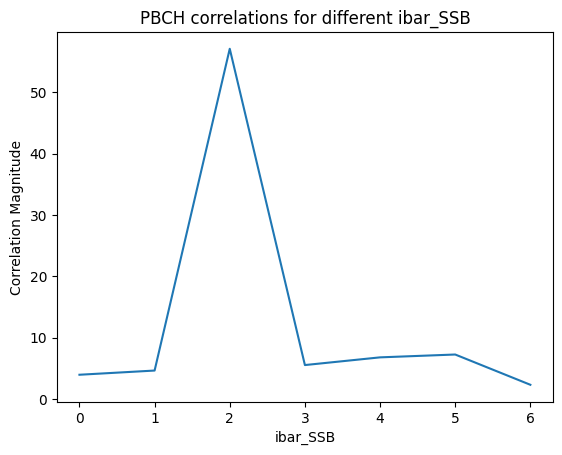

ibar_SSB is 2


In [ ]:
# Generate the indices for PBCH DM-RS symbols for the detected NID
dmrsIndices = nrPBCHDMRSIndices(detected_NID, style='matlab')

# Debug: Check DM-RS Indices and Grid Sizes
print(f"DM-RS Indices: {dmrsIndices.size}")
print(f"Size of flattened refGrid: {refGrid.size}")

# Initialize an array to store the correlation results for each ibar_SSB value
xcorrPBCHDMRS = np.empty(7)

# Loop over all possible ibar_SSB values (0 to 6)
for ibar_SSB in range(7):
    # Generate the reference PBCH DM-RS sequence for the current ibar_SSB value
    PBCHDMRS = nrPBCHDMRS(detected_NID, ibar_SSB)

    # Extract the received PBCH DM-RS symbols from the resource grid using the calculated indices
    receivedDMRS = nrExtractResources(dmrsIndices, rxGrid)

    # Compute the correlation between the received PBCH DM-RS symbols and the reference PBCH DM-RS sequence
    xcorrPBCHDMRS[ibar_SSB] = np.abs(np.vdot(receivedDMRS, PBCHDMRS))

# Identify the ibar_SSB value that yields the highest correlation
ibar_SSB = np.argmax(np.abs(xcorrPBCHDMRS))

# Plot the correlation results for each ibar_SSB value
plt.plot(np.abs(xcorrPBCHDMRS))
plt.xlabel('ibar_SSB')
plt.ylabel('Correlation Magnitude')
plt.title('PBCH correlations for different ibar_SSB')
plt.show()

# Print the detected ibar_SSB value
print(f'ibar_SSB is {ibar_SSB}')


# Setting up the reference grid with PBCH DM-RS and SSS symbols.

---



In [ ]:
# Initialize the reference grid for SSB with complex values
refGrid = np.zeros((nrbSSB * 12, 4), 'complex')

# Generate the indices for PBCH DM-RS symbols for the detected NID
dmrsIndices = nrPBCHDMRSIndices(detected_NID)

# Set up the reference grid based on a condition
if False:
    # Method 1: Manually set the DM-RS and SSS symbols in the reference grid

    # Flatten the reference grid for easier manipulation
    refGridFlat = refGrid.ravel(order='F')

    # Set the PBCH DM-RS symbols in the reference grid at the calculated indices
    refGridFlat[dmrsIndices] = nrPBCHDMRS(detected_NID, ibar_SSB)

    # Reshape the flat reference grid back to its original shape
    refGrid = refGridFlat.reshape(refGrid.shape, order='F')

    # Flatten the reference grid again
    refGridFlat = refGrid.ravel(order='F')

    # Set the SSS symbols in the reference grid at the calculated indices
    refGridFlat[sssIndices] = nrSSS(detected_NID)

    # Reshape the flat reference grid back to its original shape
    refGrid = refGridFlat.reshape(refGrid.shape, order='F')
else:
    # Method 2: Use the nrSetResources function to set the DM-RS symbols in the reference grid

    # Set the PBCH DM-RS symbols in the reference grid using the nrSetResources function
    nrSetResources(dmrsIndices, refGrid, nrPBCHDMRS(detected_NID, ibar_SSB))

DM-RS Indices: [241 245 249 253 257 261 265 269 273 277 281 285 289 293 297 301 305 309
 313 317 321 325 329 333 337 341 345 349 353 357 361 365 369 373 377 381
 385 389 393 397 401 405 409 413 417 421 425 429 433 437 441 445 449 453
 457 461 465 469 473 477 481 485 489 493 497 501 505 509 513 517 521 525
 673 677 681 685 689 693 697 701 705 709 713 717 721 725 729 733 737 741
 745 749 753 757 761 765 769 773 777 781 785 789 793 797 801 805 809 813
 817 821 825 829 833 837 841 845 849 853 857 861 865 869 873 877 881 885
 889 893 897 901 905 909 913 917 921 925 929 933 937 941 945 949 953 957]
Size of flattened refGrid: 960


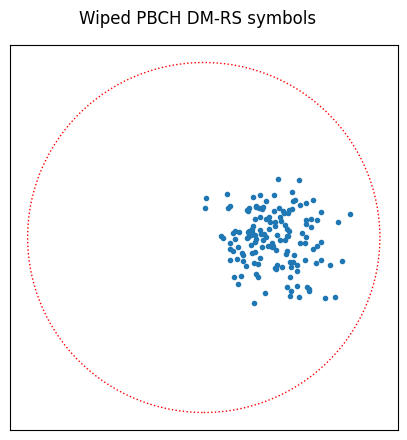

In [ ]:
# Generate the indices for PBCH DM-RS symbols for the detected NID
dmrsIndices = nrPBCHDMRSIndices(detected_NID, style='matlab')

# Debug: Check DM-RS Indices and Grid Sizes
print(f"DM-RS Indices: {dmrsIndices}")
print(f"Size of flattened refGrid: {refGrid.size}")

# Initialize the reference grid for SSB with complex values
refGrid = np.zeros((nrbSSB * 12, 4), 'complex')

# Set up the reference grid with PBCH DM-RS symbols
nrSetResources(dmrsIndices, refGrid, nrPBCHDMRS(detected_NID, ibar_SSB))

# Extract the PBCH DM-RS symbols from the received grid
receivedDMRS = nrExtractResources(dmrsIndices, rxGrid)

# Extract the reference PBCH DM-RS symbols from the reference grid
referenceDMRS = nrExtractResources(dmrsIndices, refGrid)

# "Wipe" the channel effects by dividing the received DM-RS symbols by the reference DM-RS symbols
PBCHDMRS_wiped = receivedDMRS / referenceDMRS

# Set up a plot for visualizing the "wiped" PBCH DM-RS symbols in the complex plane
fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)

# Plot the real vs imaginary parts of the "wiped" PBCH DM-RS symbols
axs.plot(PBCHDMRS_wiped.real, PBCHDMRS_wiped.imag, '.')

# Add a red circle with radius 1 centered at the origin for reference
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))

# Remove x and y ticks for a cleaner plot
axs.set_xticks([])
axs.set_yticks([])

# Adjust subplot parameters to remove spaces between subplots
fig.subplots_adjust(hspace=0, wspace=0)

# Add a title to the figure
fig.suptitle('Wiped PBCH DM-RS symbols', y=0.95)

# Display the plot
plt.show()

# Respuesta del Canal

---



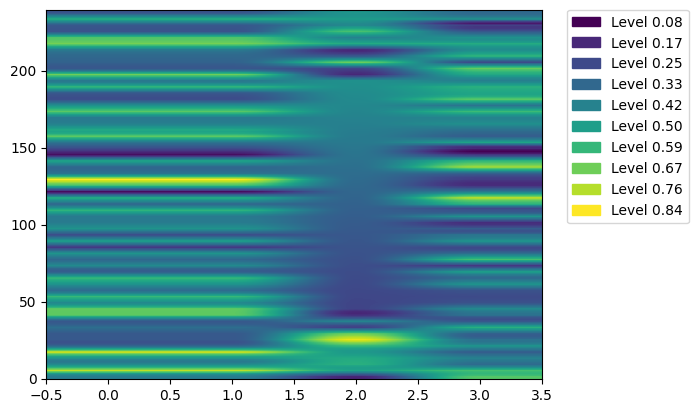

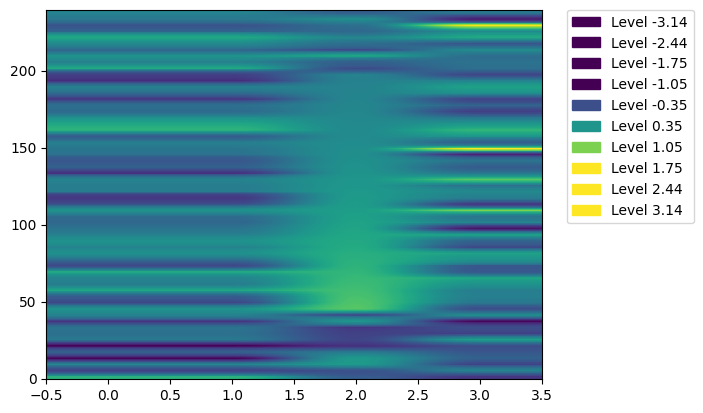

In [ ]:
import matplotlib.patches as mpatches

# Perform channel estimation using the received and reference grids
# Estimates the channel response H and noise variance nVar using the received grid (rxGrid) and reference grid (refGrid).
H, nVar = nrChannelEstimate(rxGrid=rxGrid, refGrid=refGrid)

# Plot the magnitude of the channel estimation
im = plt.imshow(np.abs(H), origin='lower', aspect='auto')
values = np.linspace(np.min(np.abs(H)), np.max(np.abs(H)), 10)  # Define levels for color patches
colors = [im.cmap(im.norm(value)) for value in values]  # Map values to colormap
patches = [mpatches.Patch(color=colors[i], label=f"Level {values[i]:.2f}") for i in range(len(values))]  # Create patches for legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # Add legend outside the plot
plt.show()

# Plot the phase of the channel estimation
im = plt.imshow(np.angle(H), origin='lower', aspect='auto')
values = np.linspace(-np.pi, np.pi, 10)  # Define levels for color patches
colors = [im.cmap(im.norm(value)) for value in values]  # Map values to colormap
patches = [mpatches.Patch(color=colors[i], label=f"Level {values[i]:.2f}") for i in range(len(values))]  # Create patches for legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # Add legend outside the plot
plt.show()


# Equalize the PBCH DM-RS symbols using the channel estimate

---



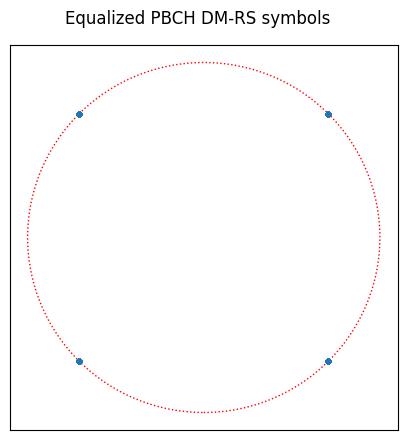

In [ ]:
# Equalize the received PBCH DM-RS symbols by dividing by the channel estimate H
PBCHDMRS_wiped = nrExtractResources(dmrsIndices, rxGrid / H)

# Set up a plot for visualizing the equalized PBCH DM-RS symbols in the complex plane
fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)

# Plot the real vs imaginary parts of the equalized PBCH DM-RS symbols
axs.plot(PBCHDMRS_wiped.real, PBCHDMRS_wiped.imag, '.')

# Add a red circle with radius 1 centered at the origin for reference
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))

# Remove x and y ticks for a cleaner plot
axs.set_xticks([])
axs.set_yticks([])

# Adjust subplot parameters to remove spaces between subplots
fig.subplots_adjust(hspace=0, wspace=0)

# Add a title to the figure
fig.suptitle('Equalized PBCH DM-RS symbols', y=0.95)

# Display the plot
plt.show()


# Equalizing and visualizing the PBCH symbols

---



evm = 0.4646167742058236


Text(0.5, 0.95, 'equilized PBCH symbols\nevm = 0.465')

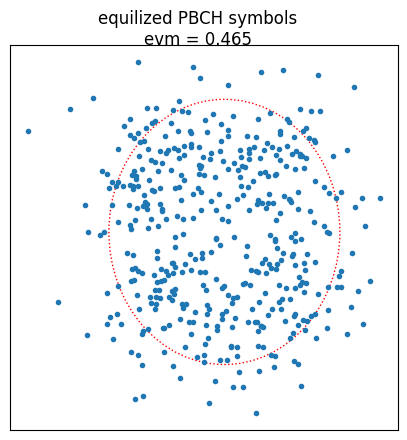

In [ ]:
# Get the indices for PBCH symbols for the detected NID
pbchIndices = nrPBCHIndices(detected_NID)

# Perform MMSE equalization on the extracted PBCH symbols
pbch_eqed, csi = nrEqualizeMMSE(
    nrExtractResources(pbchIndices, rxGrid),  # Extract PBCH symbols from received grid
    nrExtractResources(pbchIndices, H),       # Extract channel estimates for PBCH symbols
    nVar                                     # Noise variance
)

# Set up a plot for visualizing the equalized PBCH symbols in the complex plane
fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)

# Plot the real vs imaginary parts of the equalized PBCH symbols
axs.plot(pbch_eqed.real, pbch_eqed.imag, '.')

# Add a red circle with radius 1 centered at the origin for reference
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))

# Remove x and y ticks for a cleaner plot
axs.set_xticks([])
axs.set_yticks([])

# Adjust subplot parameters to remove spaces between subplots
fig.subplots_adjust(hspace=0, wspace=0)

# Calculate the Error Vector Magnitude (EVM)
evm = np.sum(np.abs(pbch_eqed - nrSymbolModulate(nrSymbolDemodulate(pbch_eqed, 'QPSK', 1, 'hard'), 'QPSK'))) / pbch_eqed.shape[0]
print(f'evm = {evm}')

# Add a title to the figure including the EVM
fig.suptitle(f'Equalized PBCH symbols\nevm = {evm:.03f}', y=0.95)

# Display the plot
plt.show()



# Decode of the PBCH bits

 After descrambling and applying CSI, then performs polar decoding and checks the CRC to verify the integrity of the decoded message.

In [ ]:
# Demodulate the equalized PBCH symbols using QPSK with soft decision
pbchBits = nrSymbolDemodulate(pbch_eqed, 'QPSK', nVar, 'soft')

# Set parameters for PBCH descrambling
E = 864  # Length of the PBCH payload
v = ibar_SSB  # Value of ibar_SSB for scrambling sequence
scrambling_seq = nrPBCHPRBS(detected_NID, v, E)  # Generate PBCH scrambling sequence
scrambling_seq_bpsk = (-1) * scrambling_seq * 2 + 1  # Convert scrambling sequence to BPSK

# Descramble the PBCH bits
pbchBits_descrambled = pbchBits * scrambling_seq_bpsk

# Apply channel state information (CSI) to the descrambled bits
pbchBits_csi = pbchBits_descrambled * np.repeat(csi, 2)

# Define parameters for polar decoding
A = 32  # Number of information bits
P = 24  # CRC length
K = A + P  # Total number of bits including CRC
N = 512  # Length of the polar code (calculated according to Section 5.3.1 of 3GPP TS 38.212)

# Perform rate recovery for polar decoding
decIn = nrRateRecoverPolar(pbchBits_csi, K, N, False, discardRepetition=False)

# Use Sionna library for polar decoding (optional, set to False to skip)
if False:
    from sionna.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
    from sionna.fec.polar.utils import generate_5g_ranking

    def interleave(K):
        # Interleaving pattern based on 38.212 Table 5.3.1.1-1
        p_IL_max_table = [0, 2, 4, 7, 9, 14, 19, 20, 24, 25, 26, 28, 31, 34, 42, 45, 49, 50, 51, 53, 54, 56, 58, 59, 61, 62, 65, 66, 67, 69, 70, 71, 72, 76, 77, 81, 82, 83, 87, 88, 89, 91, 93, 95, 98, 101, 104, 106, 108, 110, 111, 113, 115, 118, 119, 120, 122, 123, 126, 127, 129, 132, 134, 138, 139, 140, 1, 3, 5, 8, 10, 15, 21, 27, 29, 32, 35, 43, 46, 52, 55, 57, 60, 63, 68, 73, 78, 84, 90, 92, 94, 96, 99, 102, 105, 107, 109, 112, 114, 116, 121, 124, 128, 130, 133, 135, 141, 6, 11, 16, 22, 30, 33, 36, 44, 47, 64, 74, 79, 85, 97, 100, 103, 117, 125, 131, 136, 142, 12, 17, 23, 37, 48, 75, 80, 86, 137, 143, 13, 18, 38, 144, 39, 145, 40, 146, 41, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163]
        k = 0
        K_IL_max = 164
        p = np.empty(K, 'int')
        for p_IL_max in p_IL_max_table:
            if p_IL_max >= (K_IL_max - K):
                p[k] = p_IL_max - (K_IL_max - K)
                k += 1
        return p

    # Generate ranking for polar decoding
    frozen_pos, info_pos = generate_5g_ranking(K, N)
    ind_int = np.argsort(interleave(K))

    # Initialize Polar SCL decoder
    decoder = PolarSCLDecoder(frozen_pos, N, list_size=8, crc_degree='CRC24C', cpu_only=True, use_fast_scl=False, iil=True, ind_int=ind_int)

    # Decode the input bits
    decoded = np.array(decoder(np.expand_dims(-decIn, 0))[0], 'int')
    print(f'Decoded data: {decoded}')

    # Check CRC
    decoded3, crc_result = nrCRCDecode(decoded, '24C')
    if crc_result == 0:
        print("Sionna: PBCH CRC ok")
    else:
        print("Sionna: PBCH CRC failed")

if False:
    from sionna.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
    from sionna.fec.polar.utils import generate_5g_ranking

    # Initialize Polar 5G encoder and decoder
    encoder = Polar5GEncoder(32, 864, iil=True, bil=False, crc_pol="CRC24C")
    decoder = Polar5GDecoder(encoder, dec_type="SCL")

    # Decode the input bits
    decoded_no_crc = decoder(np.expand_dims(-pbchBits_csi, 0))
    decoded = decoder.u_hat_crc

    # Check CRC
    decoded3, crc_result = nrCRCDecode(decoded[0], '24C')
    if crc_result == 0:
        print("Sionna: PBCH CRC ok")
    else:
        print("Sionna: PBCH CRC failed")

# Perform polar decoding
if True:
    decoded = nrPolarDecode(decIn, K, 0, 0)
    print(f'Decoded data: {decoded}')

    # Check CRC
    decoded3, crc_result = nrCRCDecode(decoded, '24C')
    if crc_result == 0:
        print("nrPolarDecode: PBCH CRC ok")
    else:
        print("nrPolarDecode: PBCH CRC failed")


Decoded data: [0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1
 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1]
nrPolarDecode: PBCH CRC ok
